### Libs

In [1]:
%matplotlib inline

# Esconder warnings
import warnings
warnings.filterwarnings('ignore')

# Informações sobre o sistema operacional
import platform

# Análise e manipulação de dados em larga escala
import pandas as pd

# Computação científica
import numpy as np

# Manipulação de data
from datetime import datetime, timedelta

# Criação de gráficos
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams.update({'font.size': 12})

# Suporte a resultados e  gráficos dos dados estatísticos
import arviz as az

# Compilação de programas em Python em tempo de execução
from numba import jit

# Solver para o sistema de equações diferenciais
from scipy.integrate import solve_ivp

# Cálculo do máximo a posterior
from scipy.stats import gaussian_kde

# Manipulador de expressões matemáticas de alto desempenho
import theano
import theano.tensor as t

# Calibração Bayesiana
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Consts

In [2]:
# Dados
country = "Germany"
N = float(83938291)

# Modelo
R0 = float(0)
percentile_cut = 2.5

# Calibração
num_draws = 3000
init_date_cal = "2/20/20" # m/d/a
final_date_cal = "3/8/20" # m/d/a
calibration_variable_names = ["β", "γ", "I(0)", "σ"]

# Predição
num_days_predict = 7
init_date_pred = "3/9/20" # m/d/a
final_date_pred = datetime.strptime(final_date_cal, "%m/%d/%y") + timedelta(days = num_days_predict)
if platform.system() == "Windows":
    final_date_pred = final_date_pred.strftime("%#m/%#d/%y")
else:
    final_date_pred = final_date_pred.strftime("%-m/%-d/%y")

### Dados

In [3]:
data_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
confirmed_cases = pd.read_csv(data_url, sep = ",")

###############################
##### Dados de calibração #####
###############################
# Obtenção dos dados do repositório
data_cases_df = confirmed_cases.loc[confirmed_cases["Country/Region"] == country, init_date_cal : final_date_cal]

# Variáveis com dados observáveis
daily_date_cal = (pd.to_datetime(data_cases_df.keys()).to_numpy())[1:]
daily_cases_cal = np.diff(data_cases_df.to_numpy()).ravel()

# Sequencia correspondente ao número de dias com dados disponíveis
data_time_cal = np.linspace(0, daily_cases_cal.size - 1, daily_cases_cal.size)

###############################
###### Dados de predição ######
###############################
# Obtenção dos dados do repositório
data_cases_df = confirmed_cases.loc[confirmed_cases["Country/Region"] == country, init_date_pred : final_date_pred]

# Variáveis com dados observáveis
daily_date_pred = (pd.to_datetime(data_cases_df.keys()).to_numpy())[1:]
daily_cases_pred = np.diff(data_cases_df.to_numpy()).ravel()

# Sequencia correspondente ao número de dias com dados disponíveis
data_time_pred = np.linspace(data_time_cal[-1] + 1, data_time_cal[-1] + daily_cases_pred.size, daily_cases_pred.size)

## Plotando os dados

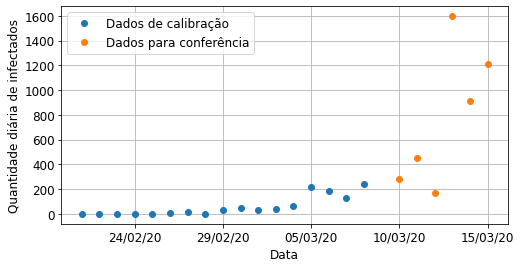

In [4]:
# Criação da figura
fig, ax = plt.subplots(figsize=[8, 4], facecolor='white')

# Plot dos dados
ax.plot(daily_date_cal, daily_cases_cal, marker="o", linewidth=0, label="Dados de calibração")
ax.plot(daily_date_pred, daily_cases_pred, marker="o", linewidth=0, label="Dados para conferência")

# Definição do formato da data no eixo horizontal
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))

# Atribuição dos nomes dos eixos
ax.set_xlabel("Data")
ax.set_ylabel("Quantidade diária de infectados");

# Linhas de grade
ax.grid()

# Legenda
ax.legend();

### Definição do modelo

In [5]:
@jit(nopython=True)
def SIR_model(t, Y, β, γ, N):
    S, I, R = Y
    dS = -β / N * S * I
    dI = β / N * S * I - γ * I
    dR = γ * I
    return dS, dI, dR

### Definição do solver

In [6]:
def model_solver(t_span, y0, t_eval, N, β, γ):
    model_pars = [β, γ, N]
    sol_ODE = solve_ivp(
        fun=lambda t, Y: SIR_model(
            t,
            Y,
            *model_pars
        ),
        t_span=t_span,
        y0=y0,
        method="LSODA",
        t_eval=t_eval
    )
    y_sol = sol_ODE.y
    return y_sol

### Simulação do modelo

In [7]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, # time_exp
        t.dscalar, # β
        t.dscalar, # γ
        t.dscalar, # I0
        t.dscalar, # R0
        t.dscalar, # N
    ],
    otypes=[t.dvector],
)
def model_wrapper(time_exp, β, γ, I0, R0, N):
    time_span = (time_exp[0], time_exp[-1])

    S0 = N - (I0 + R0)
    ICs = (S0, I0, R0)

    args = [β, γ]
    
    y_model = model_solver(time_span, ICs, time_exp, N, *args)
    infected_simulated = y_model[1]
    
    return infected_simulated

### Calibração Bayesiana

In [8]:
with pm.Model() as model_mcmc:
    β = pm.Lognormal(calibration_variable_names[0], mu=np.log(0.7), sigma=0.2)
    γ = pm.Lognormal(calibration_variable_names[1], mu=np.log(0.4), sigma=0.2)
    init_I = pm.Uniform(calibration_variable_names[2], lower=0, upper=100)
    σ = pm.Uniform(calibration_variable_names[3], lower=1, upper=100)

    fitting_model = pm.Deterministic(
        "SIR_model",
        model_wrapper(
            theano.shared(data_time_cal),
            β,
            γ,
            init_I,
            theano.shared(R0),
            theano.shared(N),
        ),
    )

    likelihood = pm.Normal("likelihood", mu=fitting_model, sigma=σ, observed=daily_cases_cal)

    trace_calibration = pm.sample_smc(
        draws=num_draws,
        n_steps=25,
        parallel=True,
        cores=8,
        progressbar=True,
        random_seed=12345
    )

Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.008 Steps:  25 Acce: 0.340
Stage:   2 Beta: 0.113 Steps:  11 Acce: 0.281
Stage:   3 Beta: 0.304 Steps:  13 Acce: 0.227
Stage:   4 Beta: 0.606 Steps:  17 Acce: 0.195
Stage:   5 Beta: 1.000 Steps:  21 Acce: 0.250


## Resumo da calibração

In [9]:
trace_summary = az.summary(
    trace_calibration,
    var_names=calibration_variable_names,
    kind="stats",
    hdi_prob=0.95,
    round_to=3
)

print(trace_summary)

        mean     sd  hdi_2.5%  hdi_97.5%
β      0.645  0.079     0.494      0.804
γ      0.412  0.073     0.280      0.560
I(0)   6.646  4.005     0.740     14.140
σ     39.959  8.269    26.308     56.326


## MAPs

{'β': 0.62079, 'γ': 0.37373, 'I(0)': 4.56597, 'σ': 36.4377}


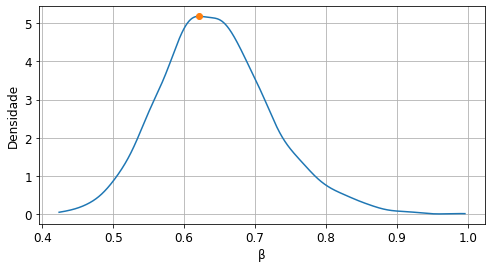

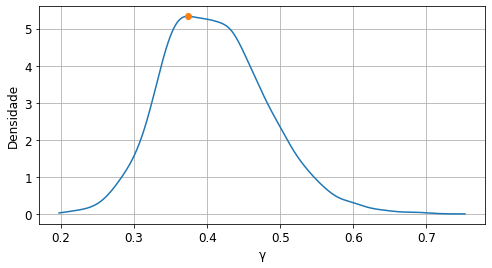

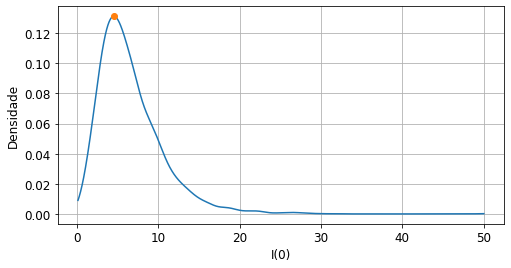

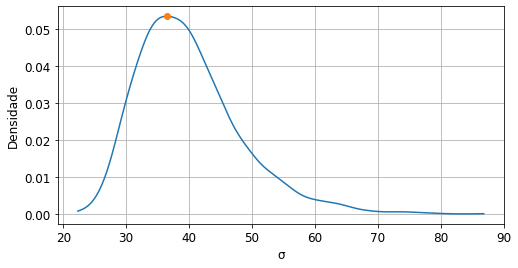

In [10]:
map_params = {}
for param in calibration_variable_names:
    range_param = np.linspace(
        trace_calibration[param].min(),
        trace_calibration[param].max(),
        num_draws
    )
    kernel = gaussian_kde(trace_calibration[param])
    kde = kernel(range_param)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = range_param[kde_max_index]
    MAP = rv_mpv_value
    map_params[param] = np.round(float(MAP), 5)
    
    # Criação da figura
    fig, ax = plt.subplots(figsize=[8, 4])
    
    # Curva da função densidade de probabilidade
    ax.plot(range_param, kde)
    
    # Ponto correspondente ao MAP
    ax.plot(rv_mpv_value, kernel(MAP), "o")
    
    # Atribuição dos nomes dos eixos
    ax.set_xlabel(f"{param}");
    ax.set_ylabel("Densidade")
    
    # Linhas de grade
    ax.grid()
    
print(map_params)

## Iterações de cada parâmetro

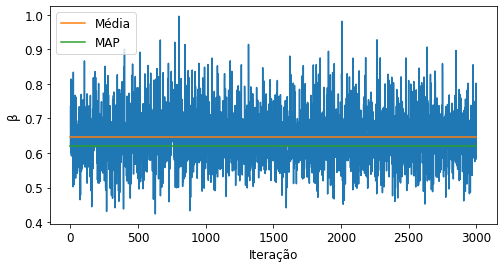

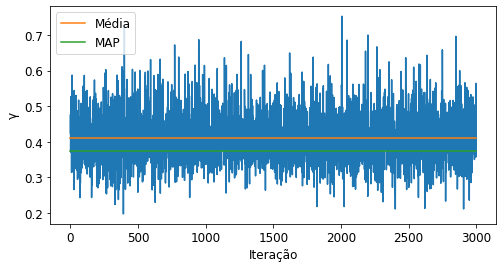

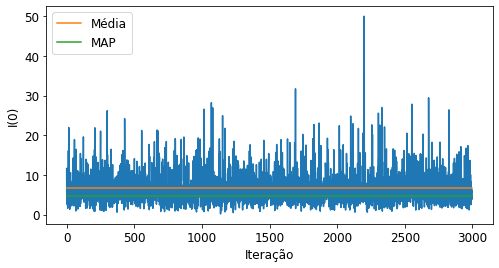

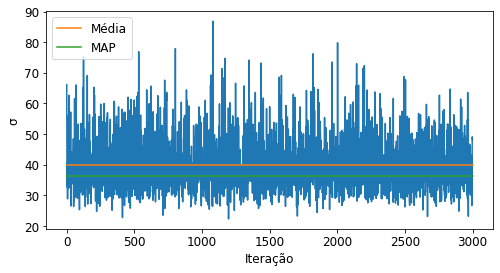

In [11]:
for variable in calibration_variable_names:
    # Criação da figura
    fig, ax = plt.subplots(figsize=[8, 4])
    
    # Plotagem das iterações
    ax.plot(trace_calibration[f"{variable}"], color="C0")
    
    # Plotagem da média
    mean_variable = trace_summary["mean"][f"{variable}"]
    ax.plot([0, num_draws], [mean_variable, mean_variable], "-", label="Média", color="C1")
    
    # Plotagem do MAP
    ax.plot([0, num_draws], [map_params[variable], map_params[variable]], "-", label="MAP", color="C2")
    
    # Atribuição dos nomes dos eixos
    ax.set_xlabel("Iteração")
    ax.set_ylabel(f"{variable}");
    
    # Legenda
    ax.legend(loc="upper left")

## Distribuição a posteriori dos parâmetros

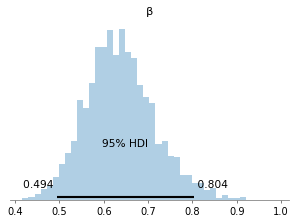

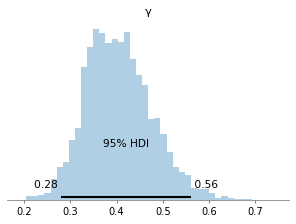

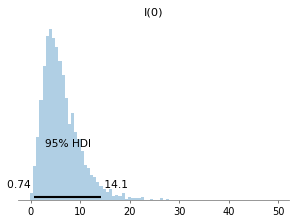

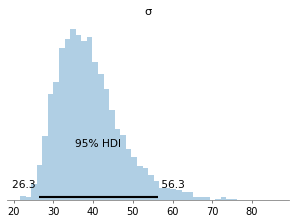

In [12]:
for variable in calibration_variable_names:
    ax = az.plot_posterior(
        trace_calibration, 
        var_names=(f"{variable}"),
        figsize=[4, 3],
        kind="hist",
        point_estimate=None,
        hdi_prob=0.95,
        round_to=3
    )

## Distribuição conjunta de parâmetros

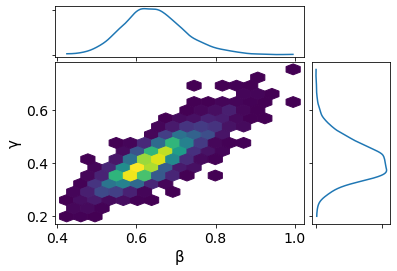

In [13]:
az.plot_joint(trace_calibration, var_names=["β", "γ"], kind='hexbin');
                                                     # kind='scatter'|'kde'|'hexbin'

## Simulação do modelo resultante

In [14]:
time_span = (data_time_cal[0], data_time_cal[-1])
S0 = N - (map_params["I(0)"] + R0)
ICs = (S0, map_params["I(0)"], R0)
map_args = [map_params["β"], map_params["γ"]]

y_fit = model_solver(time_span, ICs, data_time_cal, N, *map_args)
infected_calibration = y_fit[1]

## Incertezas

In [15]:
y_min = np.percentile(
    trace_calibration["SIR_model"],
    percentile_cut,
    axis=0
)
y_max = np.percentile(
    trace_calibration["SIR_model"],
    100 - percentile_cut,
    axis=0
)

### Boxplot das simulações

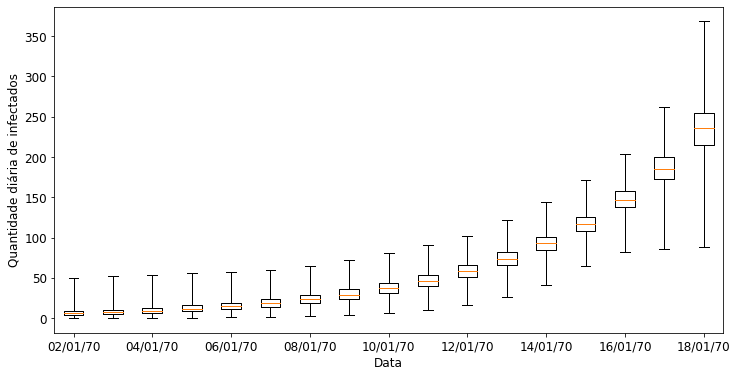

In [16]:
fig, ax = plt.subplots(figsize=[12, 6])

ax.boxplot(trace_calibration["SIR_model"], whis=(0,100));

# Definição do formato da data no eixo horizontal
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

ax.set_xlabel("Data")
ax.set_ylabel("Quantidade diária de infectados");

## Gráfico do modelo calibrado

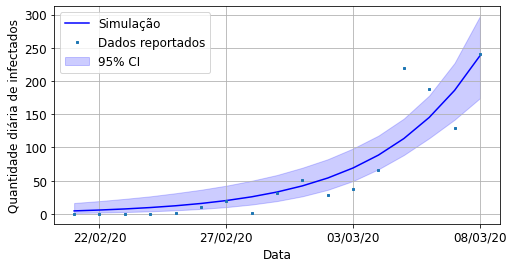

In [17]:
# Criação da figura
fig, ax = plt.subplots(figsize=[8, 4])

# Curva da simulação calculada usando os parâmetros ótimos
ax.plot(daily_date_cal, infected_calibration, "b", label="Simulação", linestyle="-", markersize=2)

# Intervalo de credibilidade
ax.fill_between(daily_date_cal, y_min, y_max, label="95% CI", color="b", alpha=0.2)

# Dados reportados
ax.plot(daily_date_cal, daily_cases_cal, label="Dados reportados", marker="s", linestyle="", markersize=2)

# Definição do formato da data no eixo horizontal
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))

# Nomes dos eixos e legenda
ax.set_xlabel("Data")
ax.set_ylabel("Quantidade diária de infectados");
ax.legend()

# Linhas de grade
ax.grid()

## Como funciona os intervalos de credibilidade

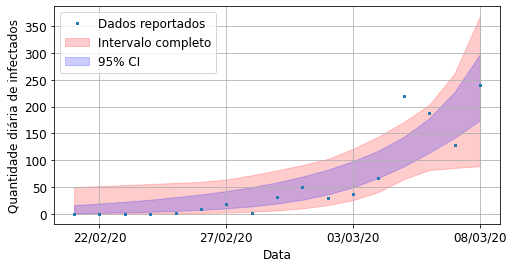

In [18]:
y_min_total = np.percentile(trace_calibration["SIR_model"], 0, axis=0)
y_max_total = np.percentile(trace_calibration["SIR_model"], 100, axis=0)

# Criação da figura
fig, ax = plt.subplots(figsize=[8, 4])

# Todos as simulações
ax.fill_between(daily_date_cal, y_min_total, y_max_total, label="Intervalo completo", color="r", alpha=0.2);
    
# Intervalo de credibilidade de 95%
ax.fill_between(daily_date_cal, y_min, y_max, label="95% CI", color="b", alpha=0.2);

# Dados reportados
ax.plot(daily_date_cal, daily_cases_cal, label="Dados reportados", marker="s", linestyle="", markersize=2)

# Definição do formato da data no eixo horizontal
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))

# Nomes dos eixos e legenda
ax.set_xlabel("Data")
ax.set_ylabel("Quantidade diária de infectados");
ax.legend(loc="upper left")

# Linhas de grade
ax.grid()

## Simulação da predição

In [19]:
data_time_cal_pred = np.concatenate((data_time_cal, data_time_pred))
time_span = (data_time_cal_pred[0], data_time_cal_pred[-1])

y_fit = model_solver(time_span, ICs, data_time_cal_pred, N, *map_args)
susceptible_prediction = y_fit[0]
infected_prediction = y_fit[1]
removed_prediction = y_fit[2]

## Intervalos de credibilidade nas predições

In [20]:
susceptible_pred = np.zeros((num_draws, data_time_cal_pred.size))
infected_pred = np.zeros((num_draws, data_time_cal_pred.size))
removed_pred = np.zeros((num_draws, data_time_cal_pred.size))

for i in range(num_draws):
    draw_β = (trace_calibration["β"])[i]
    draw_γ = (trace_calibration["γ"])[i]
    draw_I0 = (trace_calibration["I(0)"])[i]
    
    S0 = N - (draw_I0 + R0)
    ICs = (S0, draw_I0, R0)

    y_fit = model_solver(time_span, ICs, data_time_cal_pred, N, draw_β, draw_γ)
    susceptible_pred[i] = y_fit[0]
    infected_pred[i] = y_fit[1]
    removed_pred[i] = y_fit[2]

susceptible_min = np.percentile(susceptible_pred, percentile_cut, axis=0)
susceptible_max = np.percentile(susceptible_pred, 100 - percentile_cut, axis=0)

infected_min = np.percentile(infected_pred, percentile_cut, axis=0)
infected_max = np.percentile(infected_pred, 100 - percentile_cut, axis=0)

removed_min = np.percentile(removed_pred, percentile_cut, axis=0)
removed_max = np.percentile(removed_pred, 100 - percentile_cut, axis=0)

## Gráfico das predições

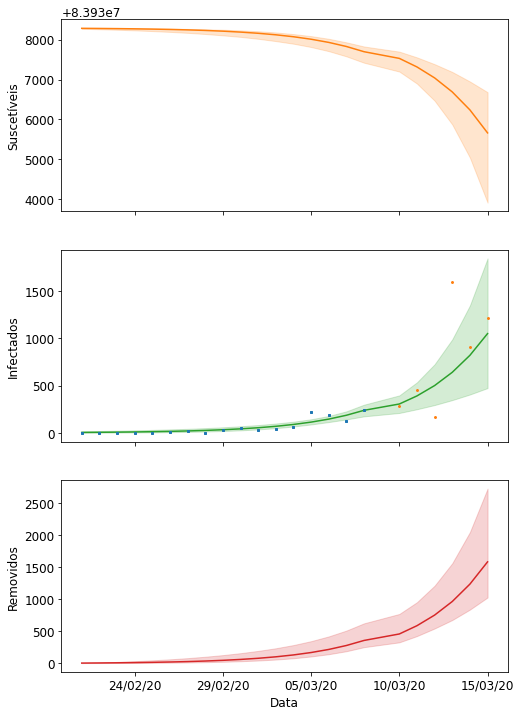

In [21]:
daily_date_cal_pred = np.concatenate((daily_date_cal, daily_date_pred))
daily_cases_cal_pred = np.concatenate((daily_cases_cal, daily_cases_pred))

# Criação da figura
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[8, 12], sharex=True)

# Curva da simulação calculada usando os parâmetros ótimos
ax1.plot(daily_date_cal_pred, susceptible_prediction, linestyle="-", markersize=2, color="C1")
ax2.plot(daily_date_cal_pred, infected_prediction, label="Simulação", linestyle="-", markersize=2, color="C2")
ax3.plot(daily_date_cal_pred, removed_prediction, linestyle="-", markersize=2, color="C3")

# Intervalo de credibilidade
ax1.fill_between(daily_date_cal_pred, susceptible_min, susceptible_max, alpha=0.2, color="C1")
ax2.fill_between(daily_date_cal_pred, infected_min, infected_max, alpha=0.2, color="C2")
ax3.fill_between(daily_date_cal_pred, removed_min, removed_max, alpha=0.2, color="C3")

# Dados reportados
ax2.plot(daily_date_cal, daily_cases_cal, label="Dados reportados", marker="s", linestyle="", markersize=2)
ax2.plot(daily_date_pred, daily_cases_pred, label="Dados reportados", marker="8", linestyle="", markersize=2)

# Definição do formato da data no eixo horizontal
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=5))

# Nomes dos eixos e legenda
ax3.set_xlabel("Data")
ax1.set_ylabel("Suscetíveis");
ax2.set_ylabel("Infectados");
ax3.set_ylabel("Removidos");